# Inicializando libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as snb
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.style.use('fivethirtyeight')

In [2]:
from lol_api.lol_dataset import api,draw_clusters,draw_fuzzy,URL_CSV_TEST
from lol_api.lol_methods import get_pos

test=api(url_csv="files/datasets/ranked_dataset.csv")
test2=api(url_csv="files/datasets/test.csv")

In [3]:
#pré-processamento dos dados 

test

# PCA

In [4]:
decomposition=test.decomposition("pca",test.Dataset_numerico.columns,3,{"random_state":7,"svd_solver":"full"})
sum(decomposition.model.explained_variance_ratio_)

0.87446797739347448

# Clusterização

In [5]:
#win cluster

def select_win(dict):
    if(dict['win']==True):
        return 0
    elif(dict['win']==False):
        return 1
win_cluster = test.get_cluster_by_features(test.Dataset_numerico.columns, select_win)
test.Cluster=win_cluster
win_cluster_transform,win_cluster_centroids=test.get_clusters_transformed()

In [6]:
# kmeans cluster
kmeans_cluster=test.cluster("kmeans",test.Dataset_numerico.columns,{"n_clusters":5,"random_state":0})
kmeans_cluster_transform,kmeans_cluster_centroids=test.get_clusters_transformed()
kmeans_cluster_transform_kwargs={"sup":kmeans_cluster_transform[0],"adc":kmeans_cluster_transform[1],
                                "jg":kmeans_cluster_transform[2],"top":kmeans_cluster_transform[4],
                                "mid":kmeans_cluster_transform[3]}
kmeans_cluster_transform=[value for value in kmeans_cluster_transform_kwargs.values()]


In [7]:
# fuzzy cluter and fpc
fuzzy_cluster=test.cluster("fuzzy",test.Dataset_numerico.columns,{})
fuzzy_cluster_transform,fuzzy_cluter_centroids=test.get_clusters_transformed()
fuzzy_cluster_transform_kwargs={"sup":fuzzy_cluster_transform[1],"adc":fuzzy_cluster_transform[3],
                                "jg":fuzzy_cluster_transform[0],"top":fuzzy_cluster_transform[2],
                                "mid":fuzzy_cluster_transform[4]}
fuzzy_cluster_transform=[value for value in kmeans_cluster_transform_kwargs.values()]
fuzzy_cluster.model.fpc

0.52563346684426571

In [8]:
# lane cluster

def select_lane(dict):
    if(dict['posição']=="sup"):
        label=0
    elif(dict['posição']=="adc"):
        label=1
    elif(dict['posição']=="jg"):
        label=2
    elif(dict['posição']=="top"):
        label=3
    else:
        label=4
    return label

position_cluster = test.get_cluster_by_features(test.Dataset_numerico.columns, select_lane)
print(len(position_cluster.model.cluster_centers_))
test.Cluster=position_cluster
lane_cluster_transform,lane_cluster_centroids=test.get_clusters_transformed()

5


# Plotting

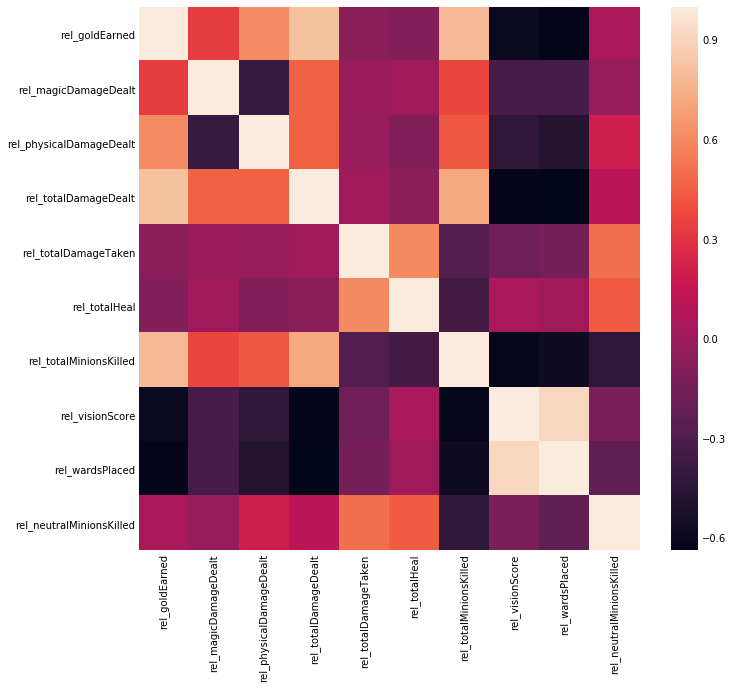

In [9]:
#correlation heatmap
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111)

snb.heatmap(test.Dataset_numerico.corr(),ax=ax)

In [10]:
#pairplot


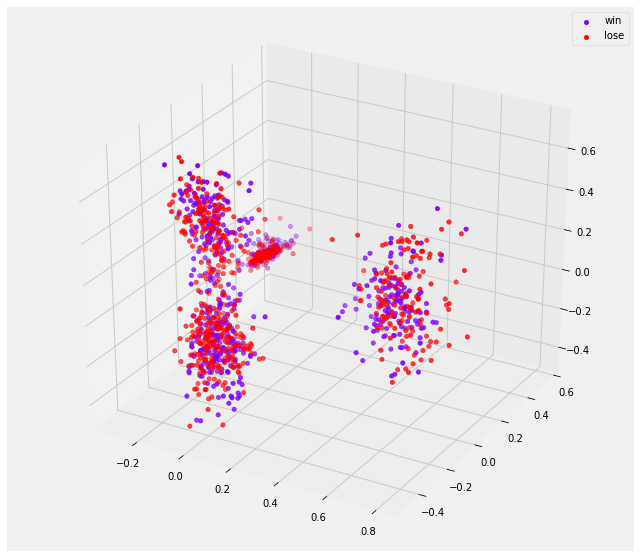

In [11]:
#plot win cluster

fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111,projection="3d")
draw_clusters(ax,win_cluster_transform,"3d",labels=["win","lose"])

Text(0.5,0.92,'lane cluster')

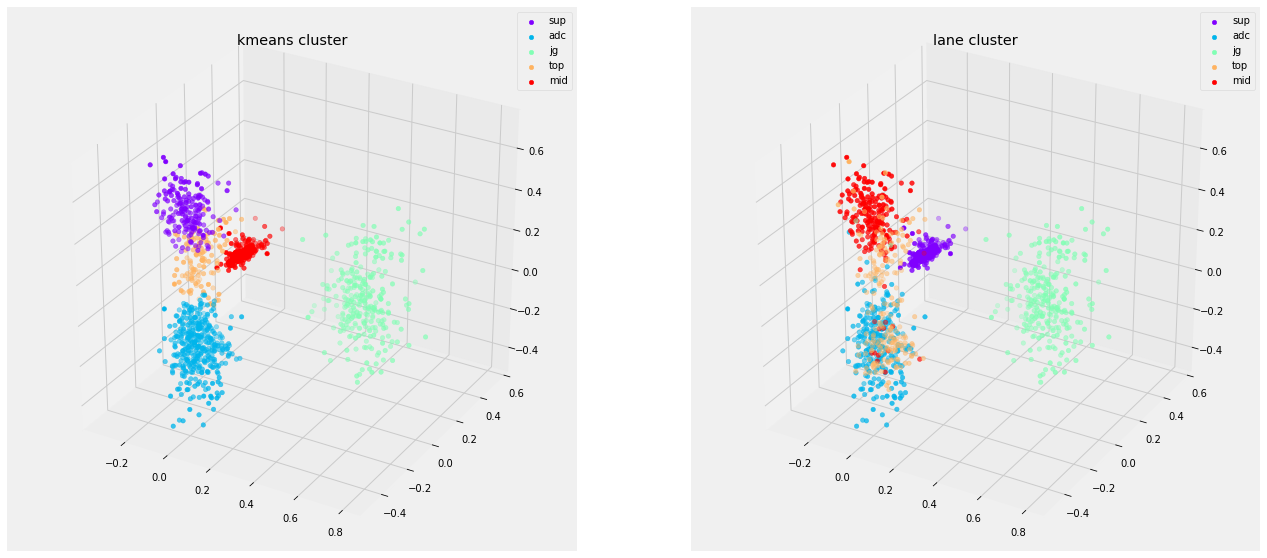

In [12]:
#plot kmeans_cluster and lane clusters

fig=plt.figure(figsize=(20,10))
ax=fig.add_subplot(121,projection="3d")
draw_clusters(ax,kmeans_cluster_transform,"3d",labels=["sup","adc","jg","top","mid"])
ax.set_title("kmeans cluster")
ax2=fig.add_subplot(122,projection="3d")
draw_clusters(ax2,lane_cluster_transform,"3d",labels=["sup","adc","jg","top","mid"])
ax2.set_title("lane cluster")

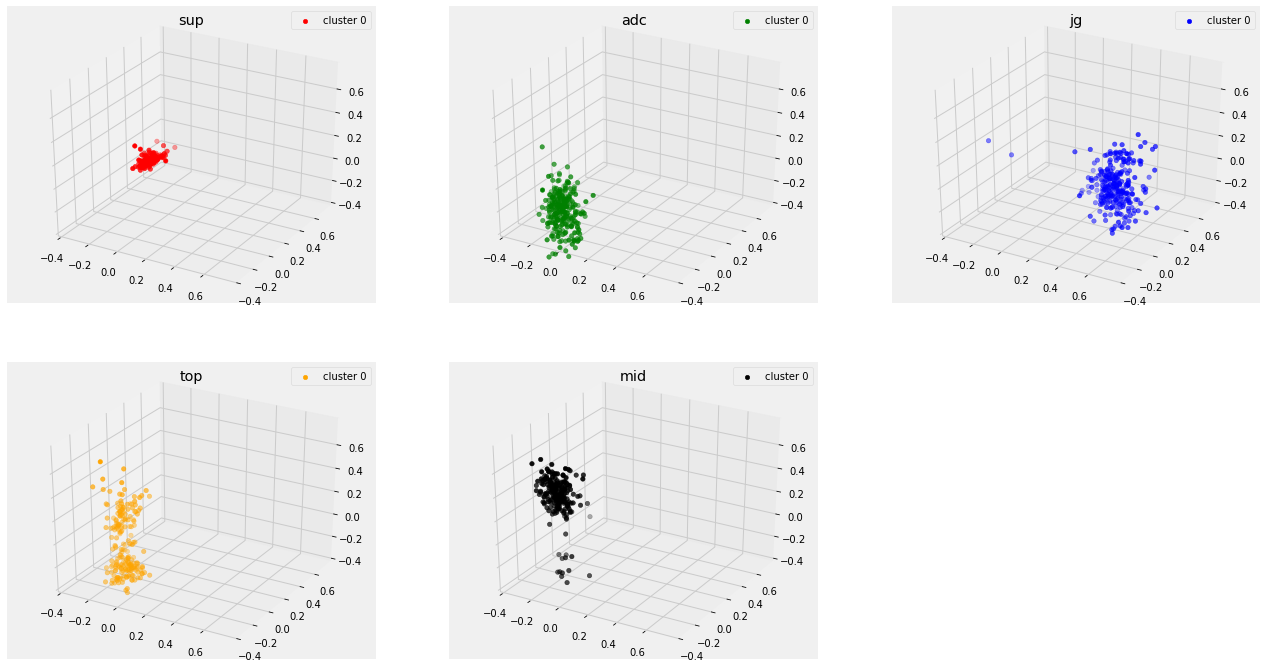

In [13]:
#plot separate lane clusters

fig=plt.figure(figsize=(20,12))

labels=["sup","adc","jg","top","mid"]
colors=["r","g","b","orange","black"]

for cont,label_name,color in zip(range(0,len(lane_cluster_transform)),labels,colors):
    ax=fig.add_subplot(2,3,cont+1,projection="3d")
    draw_clusters(ax,[lane_cluster_transform[cont]],"3d",colors=[color])
    ax.set_title(label_name)
    ax.set_xlim3d(-0.4,0.8)
    ax.set_ylim3d(-0.4,0.8)
    ax.set_zlim3d(-0.4,0.8)
    


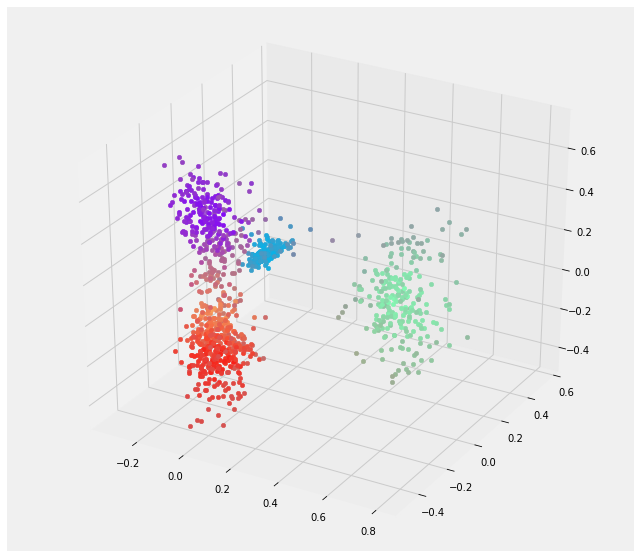

In [14]:
# fuzzy cluter
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111,projection="3d")
draw_fuzzy(ax,test.get_data_transformed(),fuzzy_cluster.model.transpose_fuzzy_partitioned_matrix,"3d")

Text(0,0.5,'FPC')

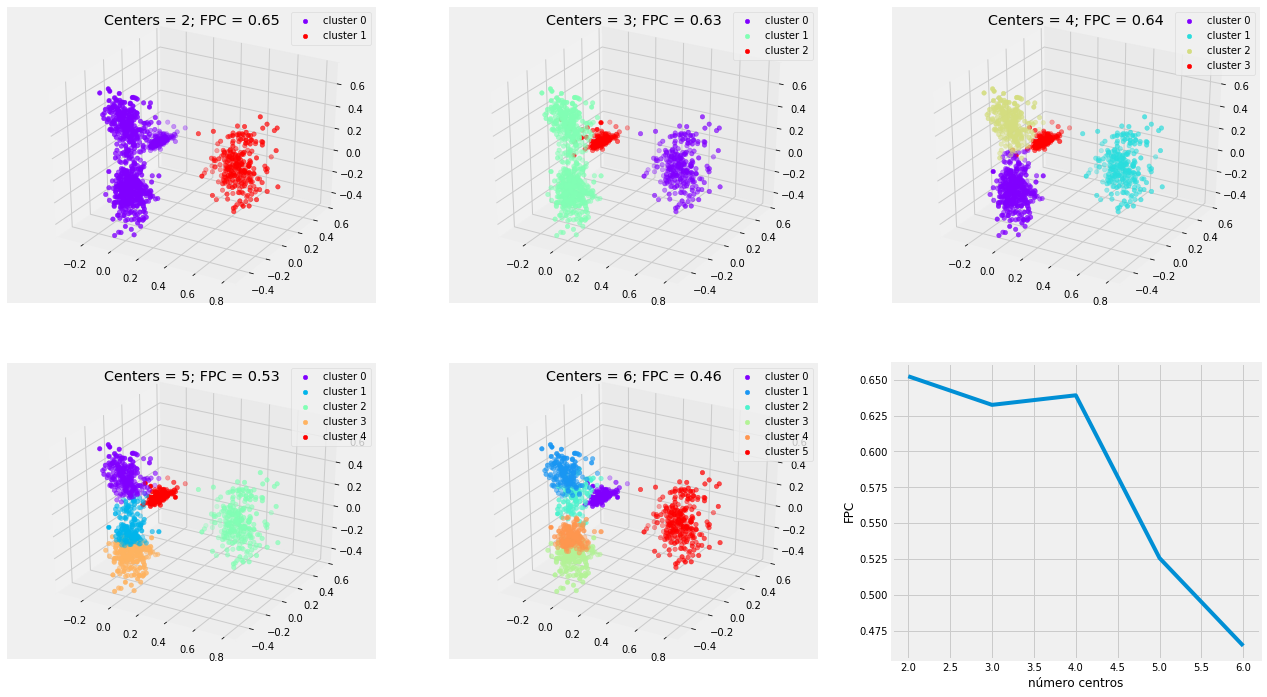

In [15]:
# fuzzy fpc plot
fig=plt.figure(figsize=(20,12))

max_nCluster=7
fpc_array=[]

for n_clusters in range(2,max_nCluster):
    ax=fig.add_subplot(2,3,n_clusters-1,projection="3d")
    _fuzzy_cluster=test.cluster("fuzzy",test.Dataset_numerico.columns,{"ncenters":n_clusters})
    _fuzzy_cluster_transform,_fuzzy_cluster_centroids=test.get_clusters_transformed()
    fpc_array.append(_fuzzy_cluster.model.fpc)
    draw_clusters(ax,_fuzzy_cluster_transform,"3d")
    ax.set_title('Centers = {0}; FPC = {1:.2f}'.format(n_clusters, _fuzzy_cluster.model.fpc))

ax=fig.add_subplot(2,3,max_nCluster-1)
ax.plot(range(2,max_nCluster),fpc_array)
ax.set_xlabel("número centros")
ax.set_ylabel("FPC")


In [16]:
# cluster kmeans evaluation

from sklearn import metrics

labels_true=[]
labels_pred=[]

for label_1,label_2 in zip(kmeans_cluster.model.labels_,position_cluster.model.labels_):
    if(label_2!=0):
        labels_true.append(label_1)
        labels_pred.append(label_2-1)


metrics_array=[]
metrics_array.append(["adjusted_rand_score",metrics.adjusted_rand_score(labels_true,labels_pred)])
metrics_array.append(["adjusted_mutual_info_score",metrics.adjusted_mutual_info_score(labels_true,labels_pred)])
metrics_array.append(["homogeneity_score",metrics.homogeneity_score(labels_true,labels_pred)])
metrics_array.append(["completeness_score",metrics.completeness_score(labels_true,labels_pred)])

cluster_evaluation_dataframe=pd.DataFrame(columns=["evaluate method name","value"],data=metrics_array)

cluster_evaluation_dataframe


,evaluate method name,value
0,adjusted_rand_score,0.662614
1,adjusted_mutual_info_score,0.667975
2,homogeneity_score,0.705431
3,completeness_score,0.669446


In [17]:
# cluster fuzzy evaluation


In [18]:
# kmeans clusters centroids

dataframe_kmeans=pd.DataFrame(columns=test.Dataset_numerico.columns,data=kmeans_cluster.model.cluster_centers_)
dataframe_kmeans["posição"]=["mid","adc","jg","sup","top"]
dataframe_kmeans

,rel_goldEarned,rel_magicDamageDealt,rel_physicalDamageDealt,rel_totalDamageDealt,rel_totalDamageTaken,rel_totalHeal,rel_totalMinionsKilled,rel_visionScore,rel_wardsPlaced,rel_neutralMinionsKilled,posição
0,0.220914,0.548964,0.036071,0.283518,0.181542,0.146007,0.294611,0.156879,0.154838,0.117327,mid
1,0.228580,0.091579,0.422409,0.248612,0.175220,0.134547,0.307595,0.150932,0.136643,0.120812,adc
2,0.188251,0.149482,0.229500,0.181548,0.263412,0.329401,0.048712,0.205008,0.185991,0.682762,jg
3,0.147529,0.048832,0.021660,0.062727,0.167408,0.183793,0.056382,0.346056,0.381422,0.003669,sup
4,0.200342,0.284149,0.129257,0.196098,0.232675,0.270379,0.270393,0.140391,0.148619,0.045317,top


# Classificação e regreção

In [19]:
models=[]
test_win_cluster=test2.get_cluster_by_features(test2.Dataset_numerico.columns, select_win)

#knn regression winning

knn_regressor=test.set_knn_regressor_model(win_cluster,weights="uniform",n_neighbors=5)
predictions_knn_regressor=knn_regressor.predict(test_win_cluster.cluster_dataset)
models.append({"type":"regression","model_name":"knn_regressor","real_values":test_win_cluster.model.labels_,
                                                  "pred_values":predictions_knn_regressor})

#knn regression decompostion

knn_regressor_decomposition=test.set_knn_regressor_model(win_cluster,True,weights="uniform",n_neighbors=5)
data_transform=test.get_data_transformed(test_win_cluster.cluster_dataset)
prediction_knn_regressor_decomposition=knn_regressor_decomposition.predict(data_transform)
models.append({"type":"regression","model_name":"knn_regressor_dec","real_values":test_win_cluster.model.labels_,
                                                             "pred_values":prediction_knn_regressor_decomposition})

#knn classifiyer winning

knn_classifiyer=test.set_knn_classification_model(win_cluster,weights="uniform",n_neighbors=5)
predictions_knn_classifiyer=knn_classifiyer.predict(test_win_cluster.cluster_dataset)
models.append({"type":"classification","model_name":"knn_classifiyer","real_values":test_win_cluster.model.labels_,
                                            "pred_values":predictions_knn_classifiyer})


#knn classifiyer decompostion

knn_classifiyer_decomposition=test.set_knn_classification_model(win_cluster,True,weights="uniform",n_neighbors=5)
data_transform=test.get_data_transformed(test_win_cluster.cluster_dataset)
prediction_knn_classifiyer_decomposition=knn_classifiyer_decomposition.predict(data_transform)
models.append({"type":"classification","model_name":"knn_classifiyer_dec","real_values":test_win_cluster.model.labels_,
                                            "pred_values":predictions_knn_classifiyer})

#mlp classifiyer winning

mlp_classifiyer=test.set_mlp_classification_model(win_cluster)
predictions_mlp_classifiyer=mlp_classifiyer.predict(test_win_cluster.cluster_dataset)
models.append({"type":"classification","model_name":"mlp_classifiyer","real_values":test_win_cluster.model.labels_,
                                            "pred_values":predictions_mlp_classifiyer})

#svc classifiyer winning

svc_classifiyer=test.set_svc_classifier_model(win_cluster)
predictions_scv_classifiyer=svc_classifiyer.predict(test_win_cluster.cluster_dataset)
models.append({"type":"classification","model_name":"svc_classifiyer","real_values":test_win_cluster.model.labels_,
                                            "pred_values":predictions_scv_classifiyer})

#tree classifiyer winning

tree_classifiyer=test.set_tree_classification_model(win_cluster)
predictions_tree_classifiyer=tree_classifiyer.predict(test_win_cluster.cluster_dataset)
models.append({"type":"classification","model_name":"tree_classifiyer","real_values":test_win_cluster.model.labels_,
                                            "pred_values":predictions_tree_classifiyer})

# Gráficos de acurácia 

In [20]:
from sklearn.metrics import mean_squared_error,f1_score

def win_loss_score(dataReal,dataPred):
    acertos=0
    for valor_real,valor_pred in zip(dataReal,dataPred):
        if(valor_real==valor_pred):
            acertos=acertos+1
    return acertos/len(dataReal)

def evaluate(dataReal,dataPred,method="rmse",**kwargs):
    if(method=="rmse"):
        return mean_squared_error(dataReal,dataPred,**kwargs)
    elif(method=="f1_score"):
        return f1_score(dataReal,dataPred,**kwargs)
    elif(method=="win_loss_score"):
        return win_loss_score(dataReal,dataPred)
    
def separate_models():
    classification_models=[]
    regression_models=[]
    for model in models:
        if(model["type"]=="classification"):
            classification_models.append(model)
        elif(model["type"]=="regression"):
            regression_models.append(model)
            
    return classification_models,regression_models

classification_models,regression_models=separate_models()

c:\users\lica\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Text(0.5,1,'Métrica:f1_score')

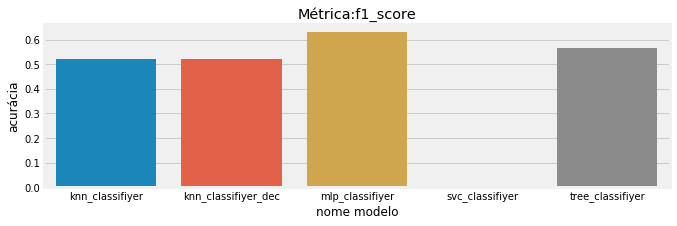

In [21]:
fig=plt.figure(figsize=(10,3))
ax=fig.add_subplot(111)

#f1_score classification
data=[]
metrica="f1_score"
for model in classification_models:
    acuracia=evaluate(model["real_values"],model["pred_values"],metrica)
    model_name=model["model_name"]
    data.append([model_name,acuracia])

f1_score_dataframe=pd.DataFrame(data=data,columns=["nome modelo","acurácia"])
ax=snb.barplot(x="nome modelo",y="acurácia",data=f1_score_dataframe,ax=ax)
ax.set_title("Métrica:"+metrica)

Text(0.5,1,'Métrica:win_loss_score')

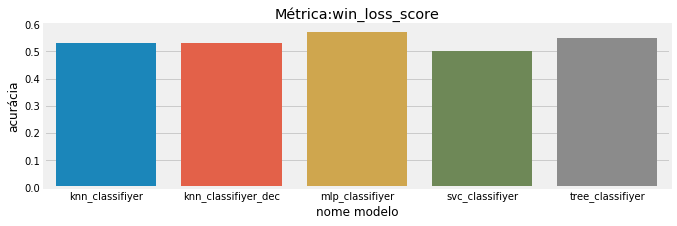

In [22]:
fig=plt.figure(figsize=(10,3))
ax=fig.add_subplot(111)

#f1_score classification
data=[]
metrica="win_loss_score"
for model in classification_models:
    acuracia=evaluate(model["real_values"],model["pred_values"],metrica)
    model_name=model["model_name"]
    data.append([model_name,acuracia])

f1_score_dataframe=pd.DataFrame(data=data,columns=["nome modelo","acurácia"])
ax=snb.barplot(x="nome modelo",y="acurácia",data=f1_score_dataframe,ax=ax)
ax.set_title("Métrica:"+metrica)

In [23]:
def set_sum_square():
    result_max_square=[]
    result_middle_square=[]
    for row in dataframe_kmeans.values:
        max_square=0
        middle_square=0
        for col in row[:-2]:
            max_square=max_square+col*1
            middle_square=middle_square+col*col
        result_max_square.append(max_square)
        result_middle_square.append(middle_square)
    
    dataframe_kmeans["soma quadrada maxima"]=result_max_square
    dataframe_kmeans["soma quadrada meio"]=result_middle_square

set_sum_square()
dataframe_kmeans

,rel_goldEarned,rel_magicDamageDealt,rel_physicalDamageDealt,rel_totalDamageDealt,rel_totalDamageTaken,rel_totalHeal,rel_totalMinionsKilled,rel_visionScore,rel_wardsPlaced,rel_neutralMinionsKilled,posição,soma quadrada maxima,soma quadrada meio
0,0.220914,0.548964,0.036071,0.283518,0.181542,0.146007,0.294611,0.156879,0.154838,0.117327,mid,2.023344,0.621505
1,0.228580,0.091579,0.422409,0.248612,0.175220,0.134547,0.307595,0.150932,0.136643,0.120812,adc,1.896116,0.485744
2,0.188251,0.149482,0.229500,0.181548,0.263412,0.329401,0.048712,0.205008,0.185991,0.682762,jg,1.781305,0.400298
3,0.147529,0.048832,0.021660,0.062727,0.167408,0.183793,0.056382,0.346056,0.381422,0.003669,sup,1.415810,0.358775
4,0.200342,0.284149,0.129257,0.196098,0.232675,0.270379,0.270393,0.140391,0.148619,0.045317,top,1.872302,0.418191


In [24]:
#set players scores

dict_centroids={}

columns_names=list(dataframe_kmeans.columns)
row_values=list(dataframe_kmeans.values)
for row in row_values:
    _dict={}
    for column_name,column_value in zip(columns_names,row):
        _dict[column_name]=column_value
    posicao=_dict['posição']
    _dict.pop("posição")
    dict_centroids[posicao]=_dict


def set_player_score(dict):
    score=0
    
    for key in test.Dataset_numerico.columns:
        score=score+dict[key]*dict_centroids[dict["posição"]][key]
      

    
    return score/dict_centroids[dict["posição"]]["soma quadrada meio"]

test.Dataset["score_kmeans"]=test.Dataset.apply(set_player_score,1)
test.Dataset.to_csv("files//datasets//ranked_dataset_score.csv")

In [25]:
test.Dataset

,Unnamed: 0,accountId,assists,champLevel,champiom,combatPlayerScore,creepsPerMinDeltas,csDiffPerMinDeltas,currentAccountId,currentPlatformId,...,unrealKills,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,win,xpDiffPerMinDeltas,xpPerMinDeltas,posição,score_kmeans
40,40,206772826,3,14,223,0,"{'10-20': 2.4, '0-10': 1.2999999999999998, '20...","{'10-20': 0.20000000000000018, '0-10': -0.8500...",206772826,KR,...,0,75,14,9,38,False,"{'10-20': 0.4000000000000341, '0-10': -38.5999...","{'10-20': 385.8, '0-10': 285.3, '20-30': 401.8}",sup,0.997553
42,42,208564646,5,15,121,0,"{'10-20': 1, '0-10': 0.30000000000000004, '20-...","{'10-20': -2.1, '0-10': -0.09999999999999998, ...",208564646,KR,...,0,59,5,11,28,False,"{'10-20': -24.5, '0-10': 7.5, '20-30': -35.299...","{'10-20': 479, '0-10': 377.9, '20-30': 431.4}",jg,2.436053
43,43,4784576,3,15,110,0,"{'10-20': 8.7, '0-10': 8, '20-30': 7.4}","{'10-20': 0.20000000000000018, '0-10': -0.8500...",4784576,KR,...,0,16,0,3,10,False,"{'10-20': 0.4000000000000341, '0-10': -38.5999...","{'10-20': 429, '0-10': 291.2, '20-30': 546}",adc,0.874286
45,45,202093245,16,15,201,0,"{'10-20': 2.3, '0-10': 1.5, '20-30': 1.3}","{'10-20': -0.20000000000000018, '0-10': 0.8500...",202093245,KR,...,0,79,9,14,34,True,"{'10-20': -0.4000000000000341, '0-10': 38.5999...","{'10-20': 350.8, '0-10': 319.5, '20-30': 532.2}",sup,0.871837
46,46,210168207,13,16,113,0,"{'10-20': 3.1, '0-10': 0.4, '20-30': 0.9}","{'10-20': 2.1, '0-10': 0.09999999999999998, '2...",210168207,KR,...,0,47,11,17,17,True,"{'10-20': 24.5, '0-10': -7.5, '20-30': 35.2999...","{'10-20': 503.5, '0-10': 370.4, '20-30': 466.7}",jg,1.875293
48,48,5482776,9,18,18,0,"{'10-20': 8.399999999999999, '0-10': 9.5, '20-...","{'10-20': -0.20000000000000018, '0-10': 0.8500...",5482776,KR,...,0,44,5,8,15,True,"{'10-20': -0.4000000000000341, '0-10': 38.5999...","{'10-20': 463.2, '0-10': 334.2, '20-30': 902.0...",adc,1.061316
60,60,207654916,7,15,3,0,"{'10-20': 6.1, '0-10': 6.7, '20-30': 5.1999999...","{'10-20': -2.1999999999999997, '0-10': -1.0999...",207654916,KR,...,0,28,2,3,16,False,"{'10-20': -102.1, '0-10': -61.19999999999996, ...","{'10-20': 414.90000000000003, '0-10': 423.2000...",mid,0.688537
61,61,7859270,15,13,412,0,"{'10-20': 0.7, '0-10': 0.1, '20-30': 0.1}","{'10-20': -1.75, '0-10': -1.4000000000000004, ...",7859270,KR,...,0,75,14,9,47,False,"{'10-20': -14.999999999999972, '0-10': -43.600...","{'10-20': 321.20000000000005, '0-10': 242.5, '...",sup,0.960755
62,62,210024119,11,16,24,0,"{'10-20': 2, '0-10': 0.7, '20-30': 2.400000000...","{'10-20': 1.0999999999999999, '0-10': 0.399999...",210024119,KR,...,0,21,6,3,9,False,"{'10-20': -26.399999999999977, '0-10': 5.19999...","{'10-20': 500.7, '0-10': 332.5, '20-30': 515.9}",jg,2.100810
63,63,208564646,8,15,51,0,"{'10-20': 8, '0-10': 7.6, '20-30': 6.8}","{'10-20': -1.75, '0-10': -1.4000000000000004, ...",208564646,KR,...,0,24,0,5,8,False,"{'10-20': -14.999999999999972, '0-10': -43.600...","{'10-20': 413.8, '0-10': 300.2, '20-30': 595.8}",adc,1.133948


In [26]:
#set train tex

dict_matchs={}

def get_matchs(dict):
    match_id=dict['gameId']
    dict.pop('gameId')
    if(match_id in dict_matchs.keys()):
        dict_matchs[match_id].append(dict)
    else:
        dict_matchs[match_id]=[dict]
    
test.Dataset.apply(get_matchs,1)

dict_valid_matchs={}
for key in dict_matchs.keys():
    if(len(dict_matchs[key])==10):
        dict_valid_matchs[key]=dict_matchs[key]


print("quantidades partidas:"+str(len(dict_valid_matchs.keys())))      

trainX=[]
trainY=[]

for key in dict_valid_matchs.keys():
    train=[]
    for player in dict_valid_matchs[key]:
        train.append(player["score_kmeans"])
    trainX.append(train)
    trainY.append(dict_valid_matchs[key][0]["win"])
    
print(len(trainX))
print(len(trainY))




quantidades partidas:86
86
86
